In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.yahoo.daily import YahooDailyReader
import datetime

from typing import Tuple

"""
Own packages
"""
from codelib.dal.fred_yield_data import get_nominal_yield_data

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

# Modelling financial markets

In this Jupyter notebook, we will discuss the modelling of financial markets. Each participant in the financial markets focus on a particular "asset universe" and are equipped with diferent investment horizons ranging from seconds to decades. E.g. the investment horisont of a proprietary trader may be a few of hours while pension funds may have a 20+ year horizon.  

I refer the interested reader to [Chapter 3 in Attilio Meucci, "Risk and Asset Allocation"](https://www.amazon.com/Risk-Asset-Allocation-Springer-Finance/dp/3642009646) for a more detailed presentation. 

## Market invariants 

We assume that an investor is interested in $N$ securities (equities, currencies, commodities, etc.) and has an investment horizon of $\tau$ years. The prices of the securties at time $t$ is represented by the vector $\mathbf{P}_t$. When talking about "modelling financial markets", we can think on modelling the distribution of the random vector $\mathbf{P}_{t + \tau}$ of the at time $t$ unknown future prices. To that end we need to find some market observables which we can use for estimating the distribution of $\mathbf{P}_{t + \tau}$

[Attilio Meucci, "Risk and Asset Allocation"](https://www.amazon.com/Risk-Asset-Allocation-Springer-Finance/dp/3642009646) discuss the concept of _market invariants_. Loosly speaking market invariants are random variables derived from the market prices which distribution does not vary over time (_time homogeneous_). Attilio Meucci suggests the following approach 

1. Detecting invariants
2. Determining the distribution of invarients
3. Projecting the invariants into the future
4. Mapping the invariants into the market prices

We say that $\mathbf{X}_{t, \Delta t}$ is a market invariant for the estimation interval $\Delta t$ (e.g. one week) if it is a random variable, independently and identically distributed and that it becomes known at time $t + \Delta t$. 

Two informal "tests" for invariance are: 

* Plot two histograms, one for each half of the data set, and compare them. It should look approximately the same. 
* Plot a scatterplot. It should not display dependence and look "random".

### Recap: Definition of returns



The __total return / gross return__ on an asset (assume that dividends are immediately reinvested) is given by 

$$
GR_{t, t-\Delta t} = \frac{P_t}{P_{t-\Delta t}} 
$$

The __linear return / net return__ is given by 

$$
R_{t, t-\Delta t} = GR_{t, t-\Delta t} -1 = \frac{P_t}{P_{t-\Delta t}} - 1 = \frac{P_t-P_{t-\Delta t}}{P_{t-\Delta t}}
$$

The __compound / log return__ is given by 

$$
r_{t, t-\Delta t} = \ln GR_{t, t-\Delta t} = \ln \frac{P_t}{P_{t-\Delta t}}  = \ln  P_t - \ln  P_{t - \Delta t}
$$

### Equities, exchange rates, etc. 

Can security prices of equties, exchange rates, etc. be market invariants? NO! Below, we see a clear dependence between current and lagged prices. 

In [2]:
"""
Download SP500 adj. closing prices since 1990
"""

sp500 = YahooDailyReader('^GSPC',start=datetime.date(1990, 1, 1)).read()
sp500.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1990-01-02,359.690002,351.980011,353.399994,359.690002,162070000,359.690002
1990-01-03,360.589996,357.890015,359.690002,358.760010,192330000,358.760010
1990-01-04,358.760010,352.890015,358.760010,355.670013,177000000,355.670013
1990-01-05,355.670013,351.350006,355.670013,352.200012,158530000,352.200012
1990-01-08,354.239990,350.540009,352.200012,353.790009,140110000,353.790009


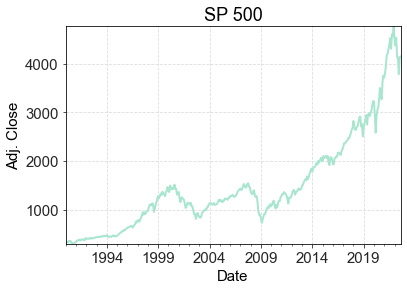

In [3]:
"""
Resample at monthly frequency and plot price development
"""

sp500_adj_close_monthly = sp500['Adj Close'].resample('M').last()
sp500_adj_close_monthly.plot(title="SP 500", ylabel="Adj. Close");

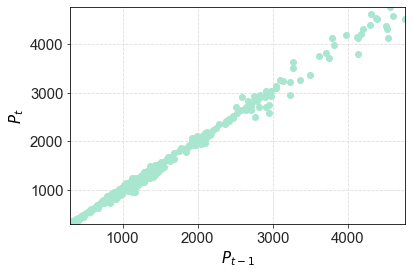

In [4]:
"""
Plot a scatter plot between the price lagged one month and the price
"""

fig, ax = plt.subplots()
ax.scatter(sp500_adj_close_monthly.shift(1), sp500_adj_close_monthly)
ax.set_xlabel('$P_{t-1}$')
ax.set_ylabel('$P_{t}$');

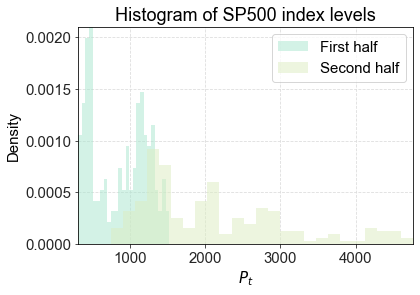

In [5]:
"""
Histogram of sample split in two
"""

half_point = int(len(sp500_adj_close_monthly) / 2)

fig, ax = plt.subplots()
ax.hist(sp500_adj_close_monthly.iloc[0:half_point], alpha=0.5,
        label="First half", bins=25, density=True)
ax.hist(sp500_adj_close_monthly.iloc[half_point:-1], alpha=0.5,
        label="Second half", bins=25, density=True)
ax.legend()
ax.set_title("Histogram of SP500 index levels")
ax.set_xlabel("$P_t$")
ax.set_ylabel("Density");

What about gross returns? Yes, it may at least be an OK approximation. 

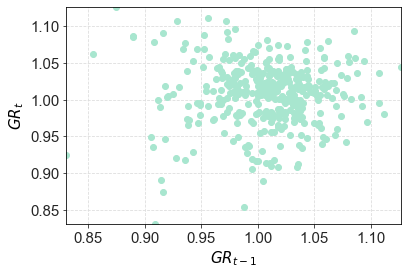

In [6]:
sp500_gross_return_monthly = sp500_adj_close_monthly/sp500_adj_close_monthly.shift(1).dropna()

"""
Plot a scatter plot between the price lagged one month and the price
"""

fig, ax = plt.subplots()
ax.scatter(sp500_gross_return_monthly.shift(1), sp500_gross_return_monthly)
ax.set_xlabel('$GR_{t-1}$')
ax.set_ylabel('$GR_{t}$');

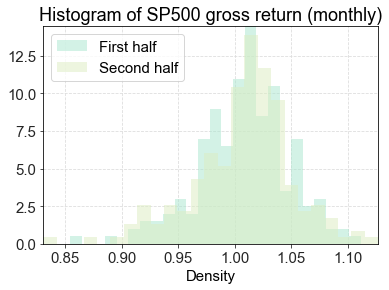

In [7]:
"""
Histogram of sample split in two
"""

half_point = int(len(sp500_gross_return_monthly) / 2)

fig, ax = plt.subplots()
ax.hist(sp500_gross_return_monthly.iloc[0:half_point], alpha=0.5, label="First half", bins=25, density=True)
ax.hist(sp500_gross_return_monthly.iloc[half_point:-1], alpha=0.5, label="Second half", bins=25, density=True)
ax.legend()
ax.set_title("Histogram of SP500 gross return (monthly)")
ax.set_xlabel("$GR_t$")
ax.set_xlabel("Density");

Since gross returns can be modelled as invariants, so can net returns and log returns. This follows directly from that if $GR_t$ is an iid random variable, so are the function of the gross return $f(GR_t)$ and from the fact that net and log returns can be written as a function of the gross return. 

What should we then use? We will typically model the distribution of log return since

1. The distribution of log returns can unlike gross and net returns easily be project to any horizon
2. Log returns typically have a symmetric distribution which makes modelling easier

### Bonds

Consider a zero-coupon bond $Z_t^T$  that pays 1 at maturity $T$. Note that $Z_T^T = 1$. The price of a zero coupon bond can be written as 

$$
Z_t^T = e^{- y_t^T (T-t)}
$$

where $y_t^T$ is the yield to maturity. 

Again, the bond price cannot be an invariant since the price trends upward to 1 (see below). 

In [8]:
"""
Get zero yield data, resample monthly
"""

zero_yields = get_nominal_yield_data(output_type='zero_yields').resample('M').last()
tenors = np.arange(1, 31, 1)

"""
Define step size
"""
dt = 1.0 / 12.0 

"""
Define function to calculate zero coupon price
"""

def calculate_zero_coupon_price(ttm: float, ytm: float):
    
    """
    Function that calculates price of a zero coupon bond given time to maturity
    and zero yield
    
    Parameters
    ----------
    ttm: 
        Time to maturity
    ytm: 
        Yield to maturity
    
    Returns
    -------
    float
        Zero coupon bond price
    
    """
    
    price = np.exp(-ttm * ytm)
    
    return price

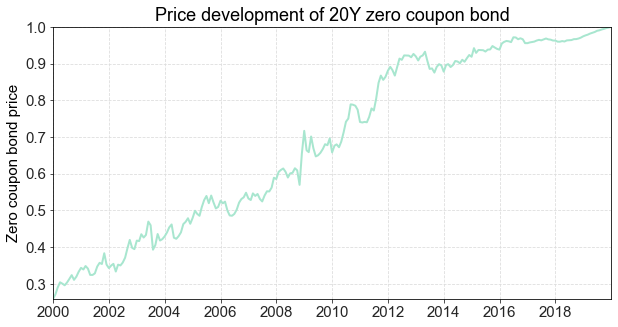

In [9]:
# import a interpolation function - we will talk more about this later
from scipy.interpolate import splev, splrep

"""
Look at the price development of a 20Y zero coupon bond from 1999-12-31 to 2019-12-31. 

Do not think to much about these calculation - we will look more into this later
"""

zero_yields_sample = zero_yields["1999-12-31":"2019-12-31"] / 100

time_to_maturity = np.arange(20.0, -0.01, -dt)
zero_coupon_prices = np.empty_like(time_to_maturity)

for i, t in enumerate(time_to_maturity):
    zero_curve_spline = splrep(tenors, zero_yields_sample.iloc[i, :].values)
    zero_coupon_prices[i] = calculate_zero_coupon_price(t, splev(t, zero_curve_spline))

    
"""
Plot price development
"""
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(zero_yields_sample.index, zero_coupon_prices)
ax.set_title('Price development of 20Y zero coupon bond')
ax.set_ylabel('Zero coupon bond price');

Simple looking at gross returns does not work either! When the time to maturity decreases the zero coupon bond becomes less risky and therefore the distribution change. Hence, there is a lack of _time homogeneity_. 

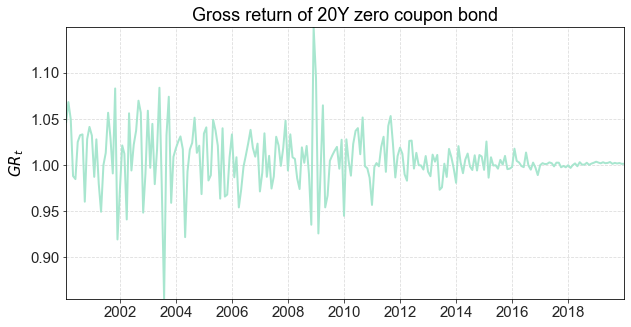

In [10]:
zc_gross_return = zero_coupon_prices[1:]/zero_coupon_prices[:-1]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(zero_yields_sample.index[1:], zc_gross_return)
ax.set_title('Gross return of 20Y zero coupon bond')
ax.set_ylabel('$GR_t$');

However, the ratio

$$
H_{t, \Delta t}^T = \frac{Z_t^T}{Z_{t- \Delta t}^{T - \Delta t}}
$$

will be an invariant. 

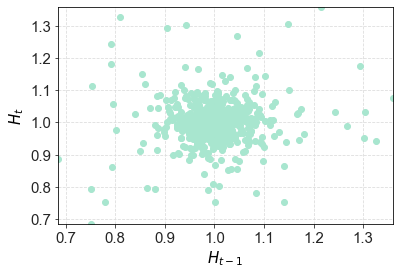

In [11]:
zero_yield_10y = zero_yields['SVENY10']
zero_yield_10y_ratio = zero_yield_10y / zero_yield_10y.shift(1)

"""
Plot a scatter plot between the price lagged one month and the price
"""

fig, ax = plt.subplots()
ax.scatter(zero_yield_10y_ratio.shift(1), zero_yield_10y_ratio)
ax.set_xlabel('$H_{t-1}$')
ax.set_ylabel('$H_{t}$');

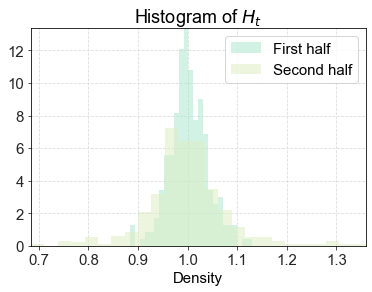

In [12]:
"""
Histogram of sample split in two
"""

half_point = int(len(zero_yield_10y_ratio) / 2)

fig, ax = plt.subplots()
ax.hist(zero_yield_10y_ratio.iloc[0:half_point], alpha=0.5, label="First half",
        bins=25, density=True)
ax.hist(zero_yield_10y_ratio.iloc[half_point:-1], alpha=0.5, label="Second half",
        bins=25, density=True)
ax.legend()
ax.set_title("Histogram of $H_t$")
ax.set_xlabel("$H_t$")
ax.set_xlabel("Density");

Again, any function of the invariant $H_t^T$ is also an invariant. A version that has the same advantages as the log return is changes in yield to maturity

$$
y_t^T - y_{t- \Delta t}^{T - \Delta t} = -\frac{1}{T-t}\log Z_t^T + \frac{1}{T-t}\log Z_{t-\Delta t}^{T - \Delta t}= -\frac{1}{T-t}\log H_t^T
$$


## Investment horizon 

If we have an investment horizon of $\tau$ years but have used an estimation interval of $\Delta t$ years (e.g. one month), then we need to translate the estimated distribution, represented via e.g. a probability density function, from the estimation interval to the investment horizon. 

Now it becomes clear why it is advantageous to use the log returns and changes in yield to maturity as markets invariants! The log return from $t$ to $t + \tau$ is simply the sum 

$$
r_{t+ \tau, \tau} = r_{t + \Delta t, \Delta t} + r_{t + 2\Delta t, \Delta t} + \dots + r_{t + \tau, t+\Delta t} 
$$

This also holds for yield changes. Thus, we have invariants that are _additive_

$$
\mathbf{X}_{t+ \tau, \tau} = \mathbf{X}_{t + \Delta t, \Delta t} + \mathbf{X}_{t + 2\Delta t, \Delta t} + \dots + \mathbf{X}_{t + \tau, \Delta t} 
$$  

which have a number of desirable properties since the non-overlapping invariants are chosen to be independent and identically distributed.  

__Moments__: 

The __expected value__ of the invariants is just the expected value over the estimation interval multiplied by the ratio between the investment horizon and estimation interval. E.g. if the investment horizon is one year and the estimation interval is one month, we multiply with 12. 

$$
\begin{align}
\text{E}[\mathbf{X}_{t+ \tau, \tau}] &= \text{E}[\mathbf{X}_{t + \Delta t, \Delta t}] + \text{E}[\mathbf{X}_{t + 2\Delta t, \Delta t}] + \dots + \text{E}[\mathbf{X}_{t + \tau, \Delta t}] \\
&= \frac{\tau}{\Delta t}\text{E}[\mathbf{X}_{t, \Delta t}]
\end{align}
$$  


The covariance matrix (the variance for a univariate invariant) is 

$$
\begin{align}
\text{Cov}[\mathbf{X}_{t+ \tau, \tau}] &= \text{Cov}[\mathbf{X}_{t + \Delta t, \Delta t}] + \text{Cov}[\mathbf{X}_{t + 2\Delta t, \Delta t}] + \dots + \text{Cov}[\mathbf{X}_{t + \tau, \Delta t}] \\
&= \frac{\tau}{\Delta t}\text{Cov}[\mathbf{X}_{t, \Delta t}]
\end{align}
$$

The standard deviations (the square root of the diagonal elements of the covariance matrix) is then simply given by (_square-root rule_)

$$
\text{Sd}[\mathbf{X}_{t+ \tau, \tau}] = \sqrt{\frac{\tau}{\Delta t}} \text{Sd}[\mathbf{X}_{t, \Delta t}]
$$

__Distribution__: 

For modelling the distribution of the whole investment horizon, it is usefull to remember that the [characteristic function](https://en.wikipedia.org/wiki/Characteristic_function_(probability_theory)) due to the iid assumption can be written as 

$$
\varphi_{\mathbf{X}_{t+ \tau, \tau}} = \left(\varphi_{\mathbf{X}_{t, \Delta t}}\right)^\frac{\tau}{\Delta t}
$$

This will often make it much easier to project the distribution to the investment horizon. 

### Example: Normal distribution 

Consider an investor that have estimated (or believes) that the distribution of log returns (the market invariants) are is given by 

$$
\mathbf{X}_{t, \Delta t} \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

where $\boldsymbol{\mu}$ is expected log returns and $\boldsymbol{\Sigma}$ is the covariance matrix of the log returns. Assume that $\Delta t = 1.0 / 12.0$ (one month) and $\tau = 5.0$ (five years). 

The characteristic function of a [multivariate normal](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) is given by 

$$
\varphi_{\mathbf{X}_{t, \Delta t}}(\omega) = e^{i \omega^\top \boldsymbol{\mu} - \frac{1}{2}\omega^\top \boldsymbol{\Sigma} \omega}
$$

Then, using our rule for the characteristic function, we obtain

$$
\varphi_{\mathbf{X}_{t+ \tau, \tau}} (\omega)  = \left(\varphi_{\mathbf{X}_{t, \Delta t}}\right)^\frac{\tau}{\Delta t} = e^{i \omega^\top \boldsymbol{\mu}\frac{\tau}{\Delta t} - \frac{1}{2}\omega^\top \boldsymbol{\Sigma} \omega \frac{\tau}{\Delta t}}
$$

Thus, it must be the case that 


$$
\mathbf{X}_{t + \tau , \tau} \sim N\left(\frac{\tau}{\Delta t}\boldsymbol{\mu}, \frac{\tau}{\Delta t}\boldsymbol{\Sigma}\right)
$$

or in our particular example

$$
\mathbf{X}_{t + \tau , \tau} \sim N\left(60 \boldsymbol{\mu}, 60 \boldsymbol{\Sigma}\right)
$$

## From invariants  to market prices

After we have determined the distribution of the invariants over the investment horizon, we need to recover the distribution of the variables of interest, namely $\mathbf{P}_{t + \tau}$. 

Both if we consider log returns of e.g. equities and the yield changes of zero-coupon bonds, we can write respectively

$$
P_{t + \tau} = P_t e^{X_{t+\tau}}
$$

and 

$$
Z_{t+\tau}^T = Z_{t}^{T-\tau}e^{-(T-t -\tau)\frac{1}{T-t-\tau}\log H_{t+\tau, \tau}^T} = Z_{t}^{T-\tau}e^{-(T-t -\tau)
X_{t+\tau}}
$$

Thus, in the two cases, we can write the vector of prices as 

$$
\mathbf{P}_{t+\tau} = e^{\mathbf{A} + \mathbf{B} \mathbf{X}_{t+\tau}}
$$

where $\mathbf{A}$ is a vector which $n$'th element equal to $\log P_t$ if the security is a stock and  $\log Z_{t}^{T-\tau}$ if a bond. $\mathbf{B}$ is a diagonal matrix with the $n$'th diagonal element equal to 1 if a stock and $-(T-t-\tau)$ if a bond. 

Using the rules of [characteristic functions](https://en.wikipedia.org/wiki/Characteristic_function_(probability_theory)) it can be usefull to note (for calculating moments). 

$$
\varphi_{\mathbf{A} + \mathbf{B} \mathbf{X}_{t+\tau}}  = e^{i\omega^\top \mathbf{A}}\varphi_{\mathbf{B} \mathbf{X}_{t+\tau}}
$$

Generally, there is no closed-form solution to the distribution of 

$$
\mathbf{P}_{t+\tau} = e^{\mathbf{A} + \mathbf{B} \mathbf{X}_{t+\tau}}
$$

However, if the invariants are assumed normal then the prices will follow a log-normal distribution. In other cases, we may need to resort to simulations. 

### Example: Normal distribution 

Consider an investor that has estimated (or believes) that the distribution of log returns (the market invariants) is given by 

$$
\mathbf{X}_{t, \tau} \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

where $\boldsymbol{\mu}$ is expected log returns and $\boldsymbol{\Sigma}$ is the covariance matrix of the log returns (the distribution is already projected to the investment horizon)

Since $\mathbf{A} + \mathbf{B} \mathbf{X}_{t+\tau}$ is an affine transformation it is also normally distributed

$$
\mathbf{A} + \mathbf{B} \mathbf{X}_{t+\tau} \sim N\left(\mathbf{A} +  \mathbf{B}\boldsymbol{\mu}, \mathbf{B}\boldsymbol{\Sigma}\mathbf{B}^\top  \right)
$$

Then by definition 
$$
\mathbf{P}_{t+\tau} \sim \log N \left(\mathbf{A} +  \mathbf{B}\boldsymbol{\mu}, \mathbf{B}\boldsymbol{\Sigma}\mathbf{B}^\top  \right)
$$

If the investor was interested in the distribution of gross return, then 

$$
\frac{\mathbf{P}_{t+\tau}}{\mathbf{P}_{t}} \sim \log N \left(\mathbf{B}\boldsymbol{\mu}, \mathbf{B}\boldsymbol{\Sigma}\mathbf{B}^\top  \right)
$$

Using that $\mathbf{B}$ is a diagonal matrix with ones in the diagonal yields

$$
\frac{\mathbf{P}_{t+\tau}}{\mathbf{P}_{t}} \sim \log N \left(\boldsymbol{\mu}, \boldsymbol{\Sigma} \right)
$$

# References

## Books

[Attilio Meucci, "Risk and Asset Allocation"](https://www.amazon.com/Risk-Asset-Allocation-Springer-Finance/dp/3642009646)